# Environment

In [1]:
from random import randint
import pytorch_lightning as pl
from IPython.display import Audio
from helpers.path_utils import get_base_dir
from model import CoraTechDataset, CoraTechModel
from torch.utils.data import DataLoader, random_split
from helpers.plot import compare_audios, plot_wavelet_spectrogram, plot_audio_fft

CHUNK_SECS = 2
TENSORS_DIR = get_base_dir().joinpath("data", "model", "train")
sample_rate = 4000

# Instance Dataset

In [2]:
cora_dataset = CoraTechDataset(TENSORS_DIR, CHUNK_SECS)
n_samples = len(cora_dataset)

print(f"Number of samples: {n_samples}")

Number of samples: 115


# Compare heartbeats

#58 / 115
mobile shape, mean and std:  torch.Size([1, 8000]) tensor(2.4145e-06) tensor(1.0000)
stethos shape, mean and std:  torch.Size([1, 8000]) tensor(2.3224e-06) tensor(1.)


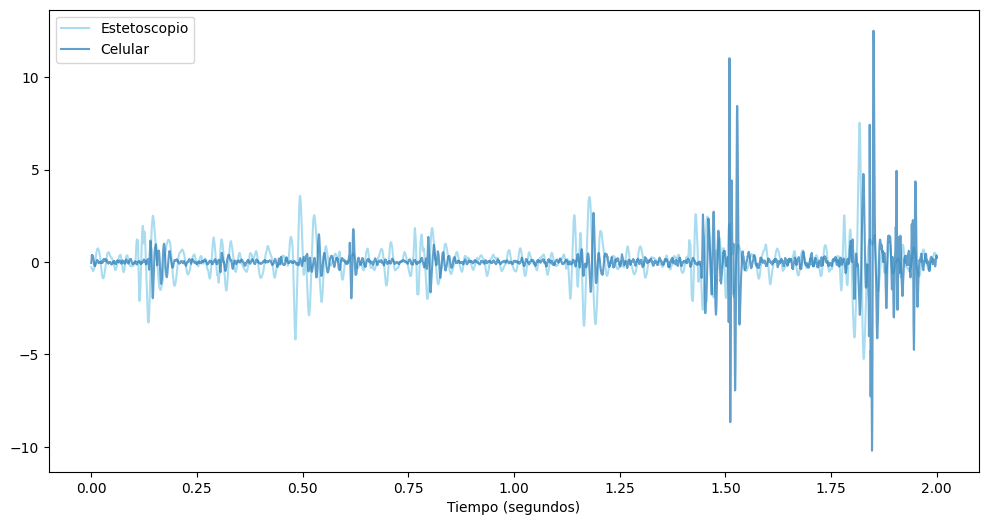

In [3]:
choosen_one = randint(0, n_samples)
print(f"#{choosen_one} / {n_samples}")

mobile_sample, stethos_sample = cora_dataset[choosen_one]

print(
    "mobile shape, mean and std: ",
    mobile_sample.shape,
    mobile_sample.mean(),
    mobile_sample.std(),
)
print(
    "stethos shape, mean and std: ",
    stethos_sample.shape,
    stethos_sample.mean(),
    stethos_sample.std(),
)

compare_audios(mobile_sample.squeeze(), stethos_sample.squeeze(), sample_rate)

## Mobile recording

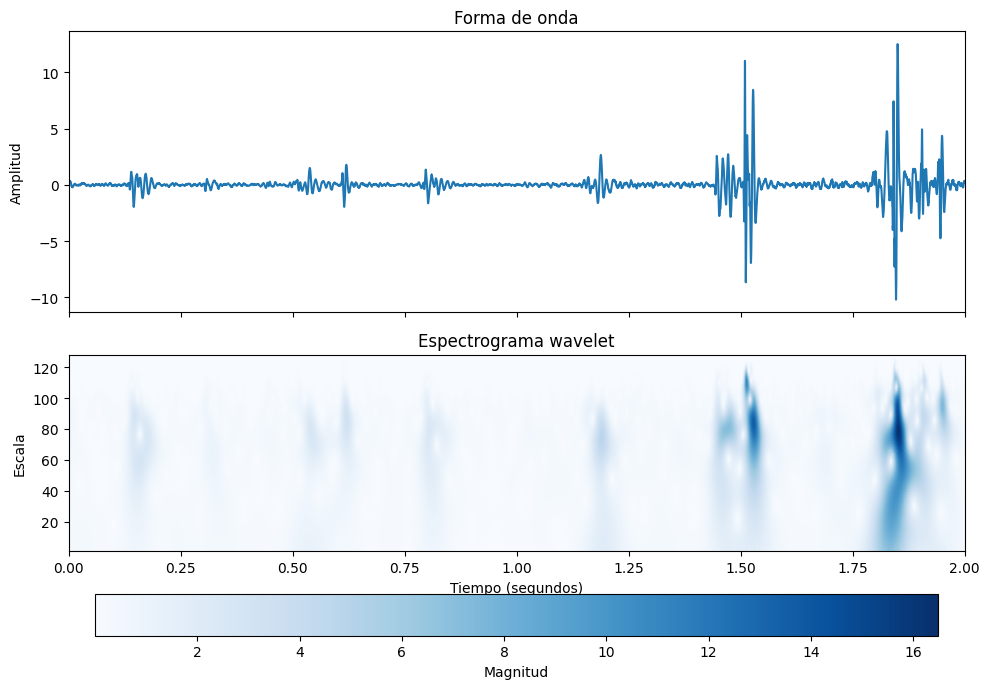

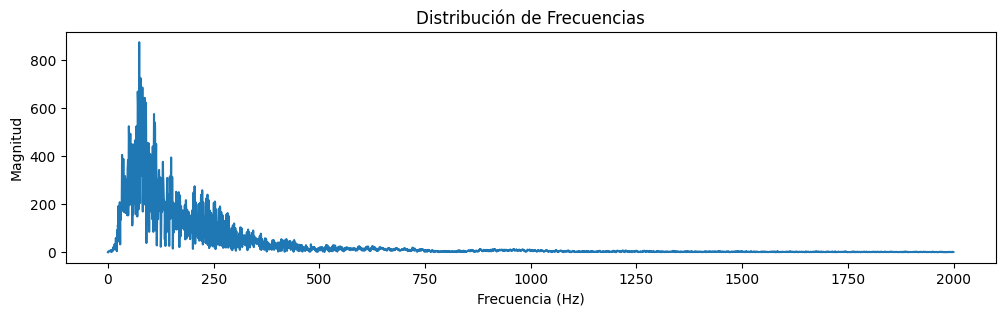

In [4]:
plot_wavelet_spectrogram(mobile_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_sample.numpy(), sample_rate)
Audio(mobile_sample, rate=sample_rate, autoplay=True)

## Stethoscope recording

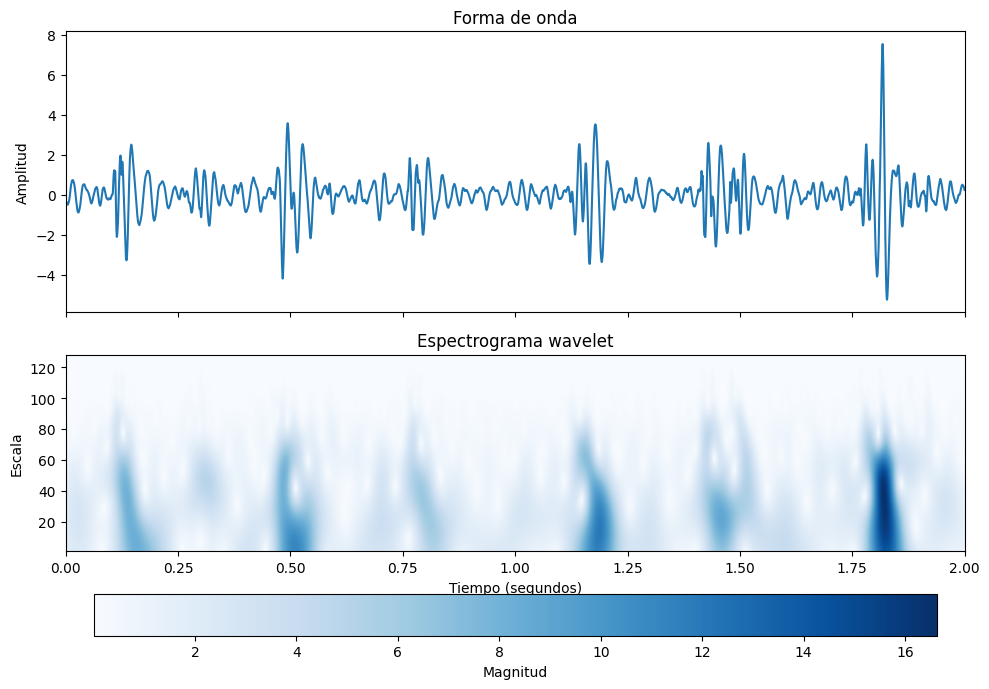

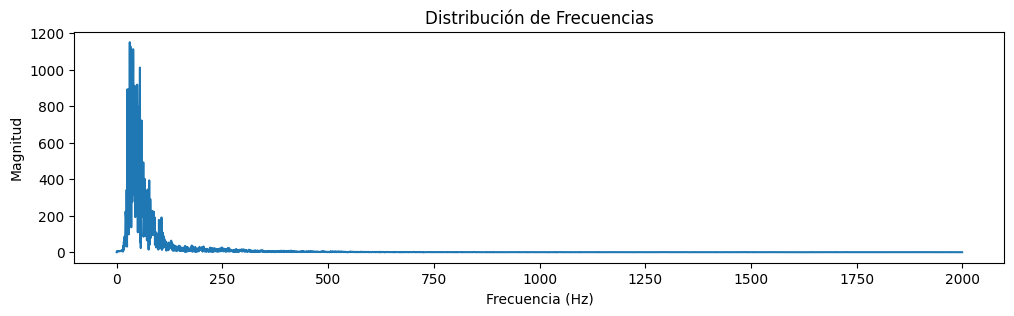

In [5]:
plot_wavelet_spectrogram(stethos_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(stethos_sample.numpy(), sample_rate)
Audio(stethos_sample, rate=sample_rate, autoplay=True)

# Train, test and validation split

In [6]:
batch_size = 10
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(cora_dataset))
val_size = int(val_ratio * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [7]:
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Train!

In [8]:
model = CoraTechModel(input_size=cora_dataset[0][0].shape[-1])

logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type   | Params | Mode 
------------------------------------------------
0 | lstm1        | LSTM   | 82.3 M | train
1 | lstm2        | LSTM   | 33.6 M | train
2 | dense1       | Linear | 4.2 M  | train
3 | dense2       | Linear | 2.1 M  | train
4 | dense3       | Linear | 1.0 M  | train
5 | output_layer | Linear | 8.2 M  | train
------------------------------------------------
131 M     Trainable params
0         Non-trainable params
131 M     Total params
525.778   Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]